# Takeaway:
- If the test error and train error converge and there is barely no gap bettwen them, then the model is great.
- Overfit or Underfit both shows a pattern that they have a big gap between the training and test error. 
- The different is that underfit often happens when the training error cannot be furthur redueced after a little epochs, while overfit often happens when there is small local mimumum in the test loss, which reflects that the model is not very complex, since some parameters have not been optimized yet (think of regularization term that reduce model complexity).


In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

## Generate Data

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

# generate features x
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

# broadcasting rule each row is expanded by the power of every element in an array with shape (1,20)
# each row of poly_features is a x^i for i = 0,...,19
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

# Each column is Divided by factorial
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
    
# compute labels y 
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

## Convert from NumPy ndarrays to tensors

In [8]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.6738],
         [0.2041]]),
 tensor([[1.0000e+00, 1.6738e+00, 1.4007e+00, 7.8148e-01, 3.2700e-01, 1.0946e-01,
          3.0536e-02, 7.3014e-03, 1.5276e-03, 2.8409e-04, 4.7549e-05, 7.2350e-06,
          1.0091e-06, 1.2993e-07, 1.5533e-08, 1.7332e-09, 1.8131e-10, 1.7851e-11,
          1.6599e-12, 1.4623e-13],
         [1.0000e+00, 2.0409e-01, 2.0827e-02, 1.4168e-03, 7.2291e-05, 2.9508e-06,
          1.0037e-07, 2.9264e-09, 7.4657e-11, 1.6930e-12, 3.4552e-14, 6.4107e-16,
          1.0903e-17, 1.7117e-19, 2.4953e-21, 3.3952e-23, 4.3308e-25, 5.1992e-27,
          5.8951e-29, 6.3323e-31]]),
 tensor([6.5586, 4.9809]))

### function to evaluate the loss on a given dataset.

In [9]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1] # the number of columns
    
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    
    # set updater/trainer
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Visualization
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    # Run
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Train the model

weight: [[ 5.0021796  1.2082253 -3.4128683  5.5950556]]


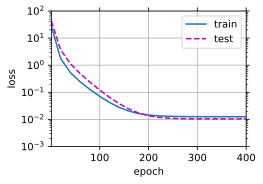

In [11]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Using 4 dimensional features is good enough.

weight: [[3.0826554 4.2845855]]


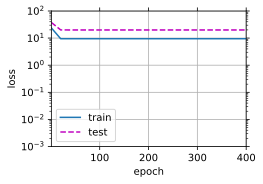

In [13]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Underfit: the test loss is always higer than train loss and the model is not able to reduce the training error, which means the model's complexity is not able to solve the regression problem. 

weight: [[ 4.9974933   1.3048538  -3.418591    5.101102   -0.0472182   1.3144337
   0.38777643  0.406144    0.1651872   0.02578206 -0.1939987   0.14743234
   0.03687552  0.18285584  0.20581205 -0.05625733 -0.12069929 -0.21164519
  -0.1987387  -0.0242133 ]]


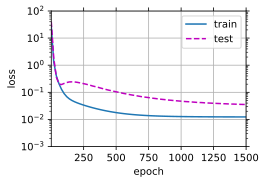

In [14]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

Overfit: the training error decreases however, there is still a big gap between the test error.